## Used vehicle auction price predictions.
Select a vehicle make, model, and trim and start processing for an estimate.

In [147]:
#@title Click play. Then select a vehicle make.
import sklearn
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression


url = 'https://raw.githubusercontent.com/martinhavens/auctiondata/main/car_prices.csv'
df = pd.read_csv(url, dtype={"year": "string", "make": "string", "model": "string","trim": "string","body": "string",
                             "transmission": "string","vin": "string","state": "string","condition": "string","odometer": "string",
                             "color": "string","interior": "string","seller": "string","mmr": "string","sellingprice": "string",
                             "saledate": "string"})

#Drop rows with condition as null
df['condition'].replace('', np.nan, inplace=True)
df['transmission'].replace('', np.nan, inplace=True)
condition1 = df['transmission'].notnull() & df['condition'].isnull()
selected_rows1 = df[condition1]
df.drop(selected_rows1.index, inplace=True)

#Drop the essential rows with NaN values
df = df.dropna(subset=['condition', 'year', 'odometer', 'mmr', 'sellingprice', 'make', 'model', 'trim']).copy()
df = df.astype({"year":int, "condition":float, "odometer":int, "mmr":int, "sellingprice":int}).copy()
#Drop the outlying sellingprice rows
q05 = df['sellingprice'].quantile(0.05)
q95 = df['sellingprice'].quantile(0.95)
df = df[(df['sellingprice'] >= q05) & (df['sellingprice'] <= q95)]

#Set the non-quantitative values to be uniform
df.loc[:,('make')] = df.loc[:,('make')].str.upper()
df.loc[:,('model')] = df.loc[:,('model')].str.upper()
df.loc[:, ('trim')] = df.loc[:, ('trim')].str.upper()

#Encode the odometer, year, and condition values
def dummiesMaker(dataFrame_variable, comparison):

  range1 = comparison['odometer'].quantile(0.2).copy()
  range2 = comparison['odometer'].quantile(0.4).copy()
  range3 = comparison['odometer'].quantile(0.6).copy()
  range4 = comparison['odometer'].quantile(0.8).copy()
  range5 = comparison['odometer'].quantile(1).copy()

  new_df = pd.DataFrame(index=dataFrame_variable.index)
  new_df['mileage_L'] = (dataFrame_variable['odometer'] < range1).astype(int)
  new_df['mileage_LM'] = ((dataFrame_variable['odometer'] >= range1) & (dataFrame_variable['odometer'] < range2)).astype(int)
  new_df['mileage_M'] = ((dataFrame_variable['odometer'] >= range2) & (dataFrame_variable['odometer'] < range3)).astype(int)
  new_df['mileage_MH'] = ((dataFrame_variable['odometer'] >= range3) & (dataFrame_variable['odometer'] < range4)).astype(int)
  new_df['mileage_H'] = (dataFrame_variable['odometer'] >= range4).astype(int)

  dataFrame_variable = pd.concat([dataFrame_variable.drop('odometer', axis=1), new_df], axis=1)

  range1 = comparison['condition'].quantile(0.2).copy()
  range2 = comparison['condition'].quantile(0.4).copy()
  range3 = comparison['condition'].quantile(0.6).copy()
  range4 = comparison['condition'].quantile(0.8).copy()
  range5 = comparison['condition'].quantile(1).copy()
  new_df = pd.DataFrame(index=dataFrame_variable.index)
  new_df['condition_L'] = (dataFrame_variable['condition'] < range1).astype(int)
  new_df['condition_LM'] = ((dataFrame_variable['condition'] >= range1) & (dataFrame_variable['condition'] < range2)).astype(int)
  new_df['condition_M'] = ((dataFrame_variable['condition'] >= range2) & (dataFrame_variable['condition'] < range3)).astype(int)
  new_df['condition_MH'] = ((dataFrame_variable['condition'] >= range3) & (dataFrame_variable['condition'] < range4)).astype(int)
  new_df['condition_H'] = (dataFrame_variable['condition'] >= range4).astype(int)
  dataFrame_variable = pd.concat([dataFrame_variable.drop('condition', axis=1), new_df], axis=1)

  range1 = comparison['year'].quantile(0.2).copy()
  range2 = comparison['year'].quantile(0.4).copy()
  range3 = comparison['year'].quantile(0.6).copy()
  range4 = comparison['year'].quantile(0.8).copy()
  range5 = comparison['year'].quantile(1).copy()
  new_df = pd.DataFrame(index=dataFrame_variable.index)
  new_df['year_L'] = (dataFrame_variable['year'] < range1).astype(int)
  new_df['year_LM'] = ((dataFrame_variable['year'] >= range1) & (dataFrame_variable['year'] < range2)).astype(int)
  new_df['year_M'] = ((dataFrame_variable['year'] >= range2) & (dataFrame_variable['year'] < range3)).astype(int)
  new_df['year_MH'] = ((dataFrame_variable['year'] >= range3) & (dataFrame_variable['year'] < range4)).astype(int)
  new_df['year_H'] = (dataFrame_variable['year'] >= range4).astype(int)
  dataFrame_variable = pd.concat([dataFrame_variable.drop('year', axis=1), new_df], axis=1)

  return dataFrame_variable

df_copy = df

#Keep only Make/Model/Trim hierachies with more than 35 instances
counts = df.groupby(['make', 'model', 'trim']).size().reset_index(name='count')
mask = counts['count'] > 35
to_remove = counts.loc[~mask, ['make', 'model', 'trim']]
df = df.set_index(['make', 'model', 'trim']).drop(to_remove.set_index(['make', 'model', 'trim']).index).reset_index()

#Split the dataframe into
train=df

from google.colab import output
output.clear()

make_list = train.make.unique()
fruit_picker = widgets.Dropdown(options=make_list, value=None, description="Make:")
fruit_picker

Dropdown(description='Make:', options=('KIA', 'VOLVO', 'NISSAN', 'CHEVROLET', 'FORD', 'BMW', 'HYUNDAI', 'CADIL…

In [148]:
#@title Click play. Then select a vehicle model.
if fruit_picker.value == None:
  print("ERROR: Select a valid 'Make' from the dropdown above. Then, Re-run this code box.")
else:
  customer_selected_data = train.loc[train['make'] == fruit_picker.value].copy()
  print(f"SUCCESS: Filtered by {fruit_picker.value} make type. ")
  model_list = customer_selected_data.model.unique()
  fruit_picker2 = widgets.Dropdown(options=model_list, value = None, description="Model:")
fruit_picker2


SUCCESS: Filtered by HONDA make type. 


Dropdown(description='Model:', options=('ACCORD', 'CR-V', 'CIVIC', 'FIT', 'PILOT', 'ODYSSEY', 'CROSSTOUR'), va…

In [149]:
#@title Click play. Then select a vehicle trim.
if fruit_picker2.value == None:
  print("ERROR: Select a valid 'Model' from the dropdown above. Then, Re-run this code box.")
else:
  customer_selected_data = customer_selected_data.loc[customer_selected_data['model'] == fruit_picker2.value]
  print(f"SUCCESS: Filtered by {fruit_picker2.value} model type. ")
  trim_list= customer_selected_data.trim.unique()
  fruit_picker3 = widgets.Dropdown(options=trim_list, value = None)
fruit_picker3

SUCCESS: Filtered by CIVIC model type. 


Dropdown(options=('LX', 'EX', 'EX-L', 'SI', 'HYBRID'), value=None)

In [150]:
#@title Click play. Then select a vehicle condition (0-low, 5-high).
if fruit_picker3.value == None:
  print("ERROR: Select a valid 'Trim' from the dropdown above. Then, Re-run this code box.")
else:
  customer_selected_data = customer_selected_data.loc[customer_selected_data['trim'] == fruit_picker3.value]
  print(f"SUCCESS: Filtered by {fruit_picker3.value} Trim type. ")
  arr_condition = np.arange(1, 5.5, 1)
  condition_dropdown = widgets.Dropdown(options=arr_condition, value=None, description='Condition:')
  arr_mileage = np.arange(0, 400000, 2000)
  mileage_dropdown = widgets.Dropdown(options=arr_mileage, value=None, description='Mileage:')
  arr_year = np.arange(1984, 2016, 1)
  
  filtered_df = df[(df['make'] == fruit_picker.value) & (df['model'] == fruit_picker2.value) & (df['trim'] == fruit_picker3.value)]
  unique_years = filtered_df['year'].unique() 
  
  year_dropdown = widgets.Dropdown(options=np.sort(unique_years), value=None, description='Year:')
condition_dropdown


SUCCESS: Filtered by SI Trim type. 


Dropdown(description='Condition:', options=(1.0, 2.0, 3.0, 4.0, 5.0), value=None)

In [151]:
#@title Click play. Then select a vehicle mileage.
if condition_dropdown.value == None:
  print("ERROR: Select a valid 'Condition' from the dropdown above. Then, Re-run this code box.")
else:
  print(f"SUCCESS: Filtered by {condition_dropdown.value} condition. ")
mileage_dropdown

SUCCESS: Filtered by 4.0 condition. 


Dropdown(description='Mileage:', options=(0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000, 20000,…

In [152]:
#@title Click play. Then select a vehicle year.
if mileage_dropdown.value == None:
  print("ERROR: Select a valid 'Milage' from the dropdown above. Then, Re-run this code box.")
else:
  print(f"CONTINUE SUCCESS: Filtered by {mileage_dropdown.value} mileage. ")
year_dropdown

CONTINUE SUCCESS: Filtered by 56000 mileage. 


Dropdown(description='Year:', options=(2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014), valu…

In [41]:
#@title Skip. But if you modified the model or trim, then click play before continuing.
customer_selected_data = train.loc[train['make'] == fruit_picker.value].copy()
customer_selected_data = customer_selected_data.loc[customer_selected_data['model'] == fruit_picker2.value]
customer_selected_data = customer_selected_data.loc[customer_selected_data['trim'] == fruit_picker3.value]

In [153]:
#@title - Click play. Start processing. Then view results.
if year_dropdown.value == None:
  print("ERROR: Select a valid 'Year' from the dropdown above. Then, Re-run this code box.")
else:
  print(f"CONTINUE SUCCESS: Filtered by {year_dropdown.value} year.")
  string_to_int = {s: i for i, s in enumerate(customer_selected_data['trim'].unique())}
  customer_selected_data['trim'] = customer_selected_data['trim'].map(string_to_int)
  comparison_for_later = customer_selected_data.copy()
  customer_selected_data = dummiesMaker(customer_selected_data, comparison_for_later)
  y = customer_selected_data["sellingprice"]
  X = customer_selected_data.drop(["sellingprice", "make", "vin", "state", "body", "color", "interior", "seller", "saledate", "model", "transmission", "mmr"], axis=1).copy()

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 21) 
  max = 0
  method = ""

  linreg=LinearRegression()
  linreg.fit(X_train,y_train)
  y_pred = linreg.predict(X_val)
  r2 = r2_score(y_val, y_pred)
  print("Linear Regression r2", r2)
  max = r2
  method = "Linear Regression"

  User_val = pd.DataFrame({'trim': ['SE'],
                      'year':    [ 2014 ],
                      'odometer': [14421],
                      'condition':[3.5]})

  User_val.at[0, 'trim'] = fruit_picker3.value
  User_val['trim'] = User_val['trim'].map(string_to_int)
  User_val.at[0, 'year'] = year_dropdown.value
  User_val.at[0, 'odometer'] = mileage_dropdown.value
  User_val.at[0, 'condition'] = condition_dropdown.value

  User_val_for_compare = User_val.copy()
  User_val = dummiesMaker(User_val, comparison_for_later)
  if method == "Linear Regression":
    Userval_pred = linreg.predict(User_val)
  elif method == "Logistic Regression":
    Userval_pred = logreg.predict(User_val)
  elif method == "Decision Tree":
    Userval_pred = dectree.predict(User_val)
  elif method == "Random Forest":
    Userval_pred = rf.predict(User_val)

  X_subset = X[User_val.columns]
  from sklearn.metrics.pairwise import cosine_similarity

  # # calculate cosine similarity between each row in the custom dataframe and each row in the original dataframe subset
  similarity_scores = cosine_similarity(User_val, X_subset)

  # find the row in the original dataframe with the highest similarity score
  index_of_most_similar_row = similarity_scores.argmax(axis=None)
  most_similar_row = X.iloc[index_of_most_similar_row]

  print("Most similar row found")
  a = comparison_for_later.iloc[index_of_most_similar_row][['year', 'odometer', 'condition']]

  for index, value in a.items():
    print(f"{index:>15}", end="")
  print("")
  for value in a.values:
    print(f"{value:>15}", end="")
  print("")

  for index, value in most_similar_row.items():
    print(f"{index:>15}", end="")
  print("")
  for index, value in most_similar_row.items():
    print(f"{value:>15}", end="")
  print("")

  print("Database price: [",y.iloc[index_of_most_similar_row], "]")
  print("User selected parameters")
  b = User_val_for_compare

  for index, value in b.items():
    if index == 'trim':
      continue
    print(f"{index:>15}", end="")
  print("")
  for value in b.values.astype(int)[0][1:]:
    print(f"{value:>15}", end="")
  print("")
  
  for index, value in User_val.items():
    print(f"{index:>15}", end="")
  print("")
  for value in User_val.values[0]:
    print(f"{value:>15}", end="")
  print("")
  print("Predicted price: [", Userval_pred[0], "]")
  


CONTINUE SUCCESS: Filtered by 2011 year.
Linear Regression r2 0.7563015246458853
Most similar row found
           year       odometer      condition
           2010          63494            3.7
           trim      mileage_L     mileage_LM      mileage_M     mileage_MH      mileage_H    condition_L   condition_LM    condition_M   condition_MH    condition_H         year_L        year_LM         year_M        year_MH         year_H
              0              0              0              0              1              0              0              0              0              1              0              0              0              1              0              0
Database price: [ 12800 ]
User selected parameters
           year       odometer      condition
           2011          56000              4
           trim      mileage_L     mileage_LM      mileage_M     mileage_MH      mileage_H    condition_L   condition_LM    condition_M   condition_MH    condition_H         year_

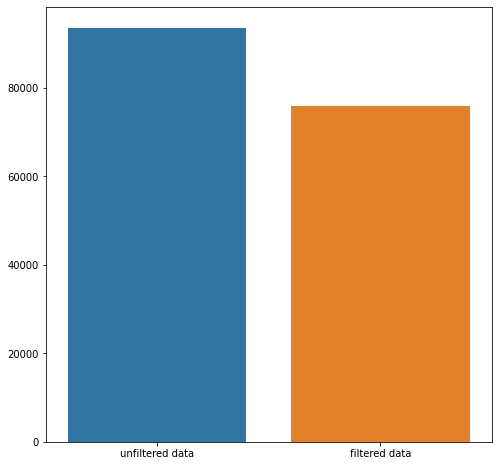

In [97]:
#Seaborn bar plot
plt.figure(figsize=(8,8))
aq = sns.barplot(x=['unfiltered data', 'filtered data'], y=[df_copy.shape[0], df.shape[0]])

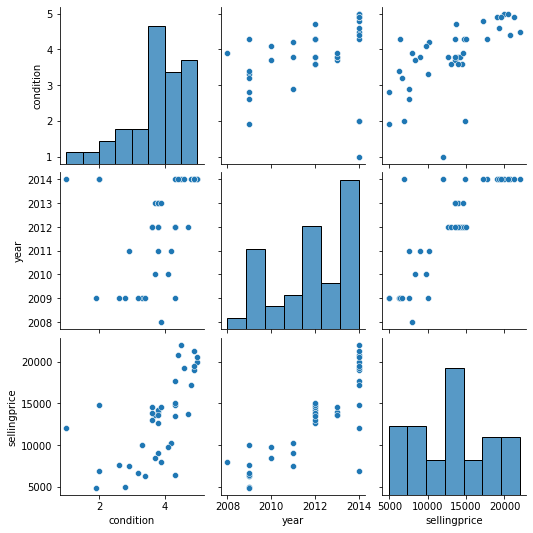

In [49]:
#Seaborn pair plot
df_3d = pd.DataFrame()
x = customer_selected_data['condition']
y = customer_selected_data['year']
z = customer_selected_data['sellingprice']
df_3d['condition'] = x
df_3d['year'] = y
df_3d['sellingprice'] = z

sns.pairplot(df_3d)

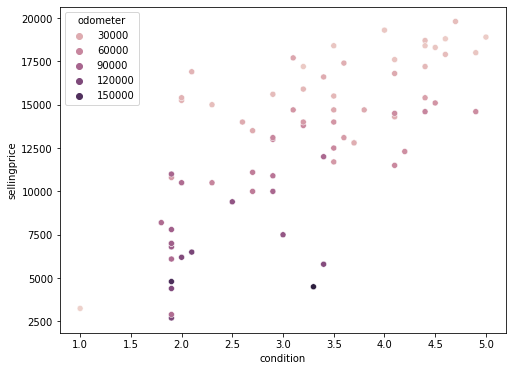

In [157]:
#Seaborn scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=comparison_for_later, x="condition", y='sellingprice', hue='odometer')
plt.show()